In [9]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [68]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, z_dim=20) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # encoder
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # input img -> Hidden dim -> mean, std -> Parametrization trick -> Decoder -> output
    def encode(self, x):
        x = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(x), self.hid_2sigma(x)
        return mu, sigma

    def decode(self, x):
        x = self.relu(self.z_2hid(x))
        x = self.hid_2img(x)
        return self.sigmoid(x)
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z_reparametrizes = mu + sigma * eps
        x_reconstructed = self.decode(z_reparametrizes)

        return x_reconstructed, mu, sigma

In [6]:
model = VariationalAutoEncoder(input_dim=28 * 28, z_dim=32).to(DEVICE)

In [7]:
NUM_EPOCH = 20
LEARNING_RATE = 1e-4

criterion = nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [41]:
min_loss = float('inf')

for epoch in range(NUM_EPOCH):

    mean_loss = []
    
    loop = tqdm(train_loader, desc=f'Epoch {epoch + 1}')

    for img, _ in loop:
        
        img = img.view(-1, 1 * 28 * 28).to(DEVICE)
        x_reconstructed, mu, sigma = model(img + torch.randn_like(img) * 0.1)

        loss = criterion(x_reconstructed, img)
        kl_divergance = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        
        loss += kl_divergance
        mean_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loop.set_postfix(loss=loss.item())

    mean_loss = sum(mean_loss) / len(mean_loss)

    print(f'Mean loss: {mean_loss:.3f}')

    if mean_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")
        min_loss = mean_loss

Epoch 1: 100%|██████████| 938/938 [00:06<00:00, 135.17it/s]


Mean loss: 8274.780


Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 133.90it/s]


Mean loss: 8273.386


Epoch 3: 100%|██████████| 938/938 [00:06<00:00, 134.20it/s]


Mean loss: 8268.842


Epoch 4: 100%|██████████| 938/938 [00:06<00:00, 135.20it/s]


Mean loss: 8284.028


Epoch 5: 100%|██████████| 938/938 [00:07<00:00, 132.89it/s]


Mean loss: 8258.557


Epoch 6: 100%|██████████| 938/938 [00:06<00:00, 136.16it/s]


Mean loss: 8258.415


Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 132.33it/s]


Mean loss: 8242.269


Epoch 8: 100%|██████████| 938/938 [00:06<00:00, 134.90it/s]


Mean loss: 8262.152


Epoch 9: 100%|██████████| 938/938 [00:06<00:00, 134.11it/s]


Mean loss: 8237.117


Epoch 10: 100%|██████████| 938/938 [00:06<00:00, 137.29it/s]


Mean loss: 8222.105


Epoch 11: 100%|██████████| 938/938 [00:06<00:00, 135.03it/s]


Mean loss: 8201.779


Epoch 12: 100%|██████████| 938/938 [00:06<00:00, 134.97it/s]


Mean loss: 8189.372


Epoch 13: 100%|██████████| 938/938 [00:07<00:00, 133.93it/s]


Mean loss: 8183.000


Epoch 14: 100%|██████████| 938/938 [00:07<00:00, 133.32it/s]


Mean loss: 8174.538


Epoch 15: 100%|██████████| 938/938 [00:07<00:00, 132.49it/s]


Mean loss: 8166.421


Epoch 16: 100%|██████████| 938/938 [00:06<00:00, 134.84it/s]


Mean loss: 8158.947


Epoch 17: 100%|██████████| 938/938 [00:06<00:00, 135.42it/s]


Mean loss: 8155.066


Epoch 18: 100%|██████████| 938/938 [00:07<00:00, 129.58it/s]


Mean loss: 8146.770


Epoch 19: 100%|██████████| 938/938 [00:07<00:00, 127.80it/s]


Mean loss: 8144.335


Epoch 20: 100%|██████████| 938/938 [00:07<00:00, 124.86it/s]

Mean loss: 8139.396


In [70]:
best_model = VariationalAutoEncoder(input_dim=28 * 28, z_dim=32)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True))
best_model = best_model.to(DEVICE)

In [77]:
images = []
labels = []

for img, label in test_loader:
    for x, y in zip(img, label):
        if y not in labels:
            labels.append(y.item())
            images.append(x)

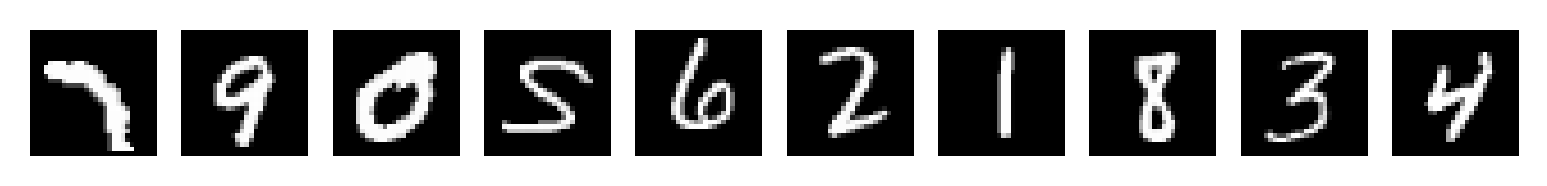

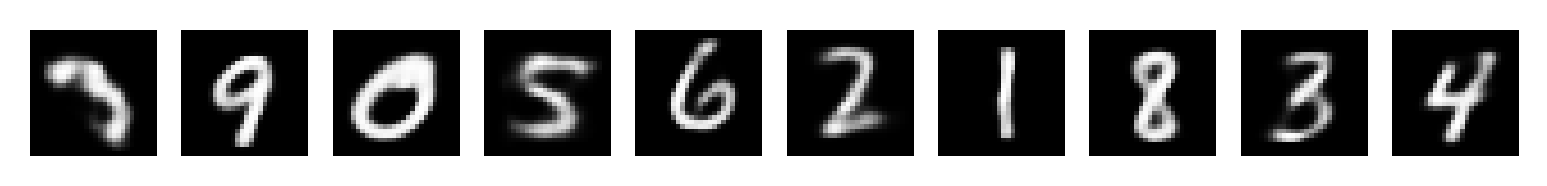

In [78]:
best_model.eval()

encodded = []
generated_imgs = []

with torch.no_grad():
    for img in images:
        mu, sigma = best_model.encode(img.view(1, 28 * 28).to(DEVICE))
        encodded.append((mu, sigma))

    for idx, (mu, sigma) in enumerate(encodded):
        eps = torch.randn_like(sigma)
        z = mu + sigma * eps
        out = best_model.decode(z)
        out = out.view(-1, 1, 28, 28).cpu().squeeze(1)

        generated_imgs.append(out)

fig, axs = plt.subplots(1, 10, dpi=300)
for ax, img in zip(axs, images):
    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.axis("off")

fig, axs = plt.subplots(1, 10, dpi=300)

for ax, img in zip(axs, generated_imgs):
    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.axis("off")

plt.show()